In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/data/facemaskdetection.zip > /dev/null

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

  Imports
  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import os
import cv2


Creating train and validation datasets


In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen =keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        "/content/Face Mask Dataset/Train",
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        "/content/Face Mask Dataset/Validation",
        target_size=(224,224),
        batch_size=64,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [4]:
labels={0:'with_mask',1:'without_mask'}

Visualizing the data

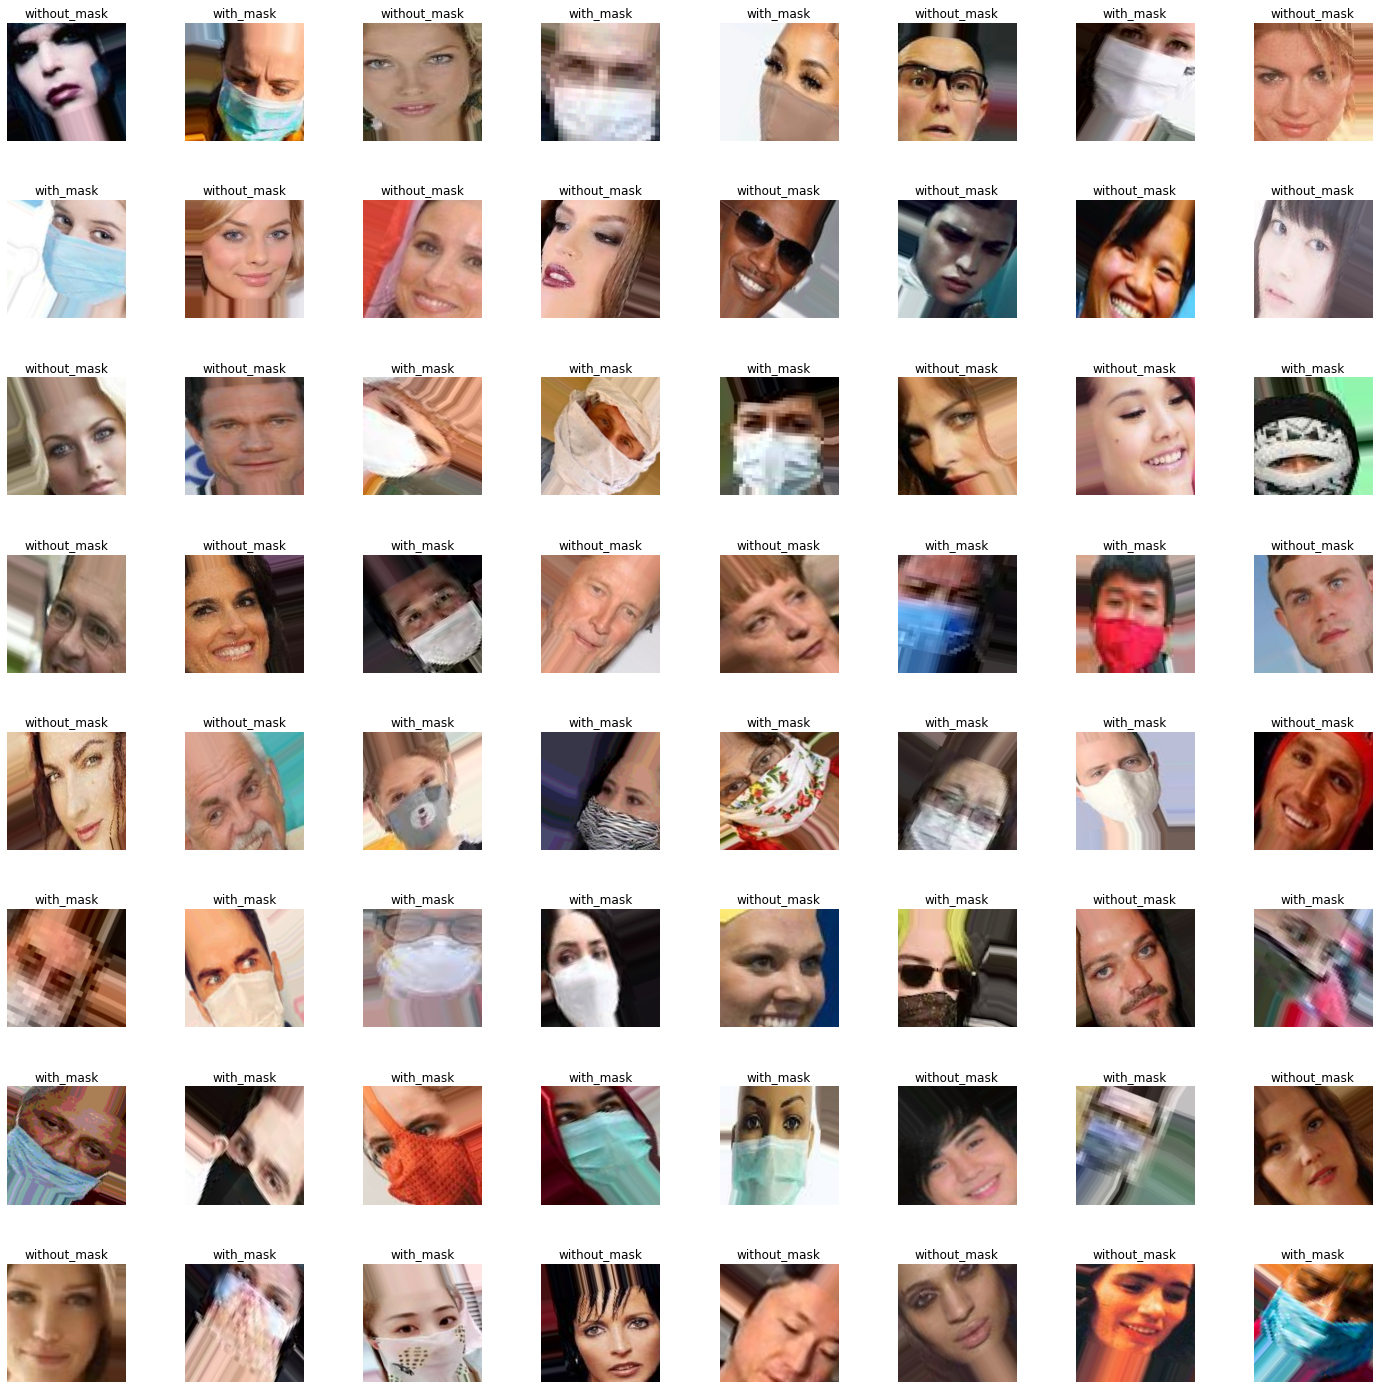

In [5]:
X_train,y_train=next(train_generator)
fig,axes=plt.subplots(8,8,figsize=(25,25))
axes=axes.ravel()#flatten 
for i in np.arange(0,64):
    axes[i].imshow(X_train[i])
    axes[i].set_title(labels[y_train[i]])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)

Creating The Model

In [6]:
from keras import layers
from keras import models
from keras.layers import Dense,Concatenate
from keras.models import Sequential
model=keras.applications.MobileNetV2(weights='imagenet')
penultimate_layer = model.layers[-2] 
new_top_layer = keras.layers.Dense(256,activation='relu')(penultimate_layer.output)  
new_top_layer = keras.layers.Dropout(0.25)(new_top_layer)  
new_top_layer = keras.layers.Dense(512,activation='relu')(new_top_layer)  
new_top_layer = keras.layers.Dense(1,activation='sigmoid')(new_top_layer) 
new_model = keras.models.Model(model.input, new_top_layer)

In [7]:
new_model.compile(optimizer=keras.optimizers.Adam(lr=3e-4),metrics=['accuracy'],loss='binary_crossentropy')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=5, min_lr=1e-5)
new_model.fit(train_generator,validation_data=validation_generator,batch_size=64,epochs=10,callbacks=[reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
157/157 [==============================] - 176s 1s/step - loss: 0.0499 - accuracy: 0.9812 - val_loss: 2.9516 - val_accuracy: 0.7287
Epoch 2/10
157/157 [==============================] - 166s 1s/step - loss: 0.0179 - accuracy: 0.9933 - val_loss: 2.3742 - val_accuracy: 0.8263
Epoch 3/10
157/157 [==============================] - 165s 1s/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0586 - val_accuracy: 0.9950
Epoch 4/10
157/157 [==============================] - 165s 1s/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.5321 - val_accuracy: 0.9475
Epoch 5/10
157/157 [==============================] - 164s 1s/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.3063 - val_accuracy: 0.9737
Epoch 6/10
157/157 [==============================] - 164s 1s/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 1.2461 - val_accuracy: 0.8800
Epoch 7/10
157/157 [==============================] - 166s 1s/step - loss: 0.0174 - accuracy: 0.9961 - val_loss: 0.0631 - val_accuracy: 0.9912

In [8]:
new_model.evaluate(train_generator)

157/157 [==============================] - 131s 834ms/step - loss: 0.0106 - accuracy: 0.9983


[0.010647223331034184, 0.9983000159263611]

Testing The Model

In [9]:
test_generator = test_datagen.flow_from_directory(
        "/content/Face Mask Dataset/Test",
        target_size=(224,224),
        batch_size=64,
        class_mode='binary')

Found 992 images belonging to 2 classes.


In [10]:
X_test, y_test = next(test_generator)
pred=np.round(new_model.predict(X_test))
predictions=[]
for i in pred:
    predictions.append(int(i[0]))

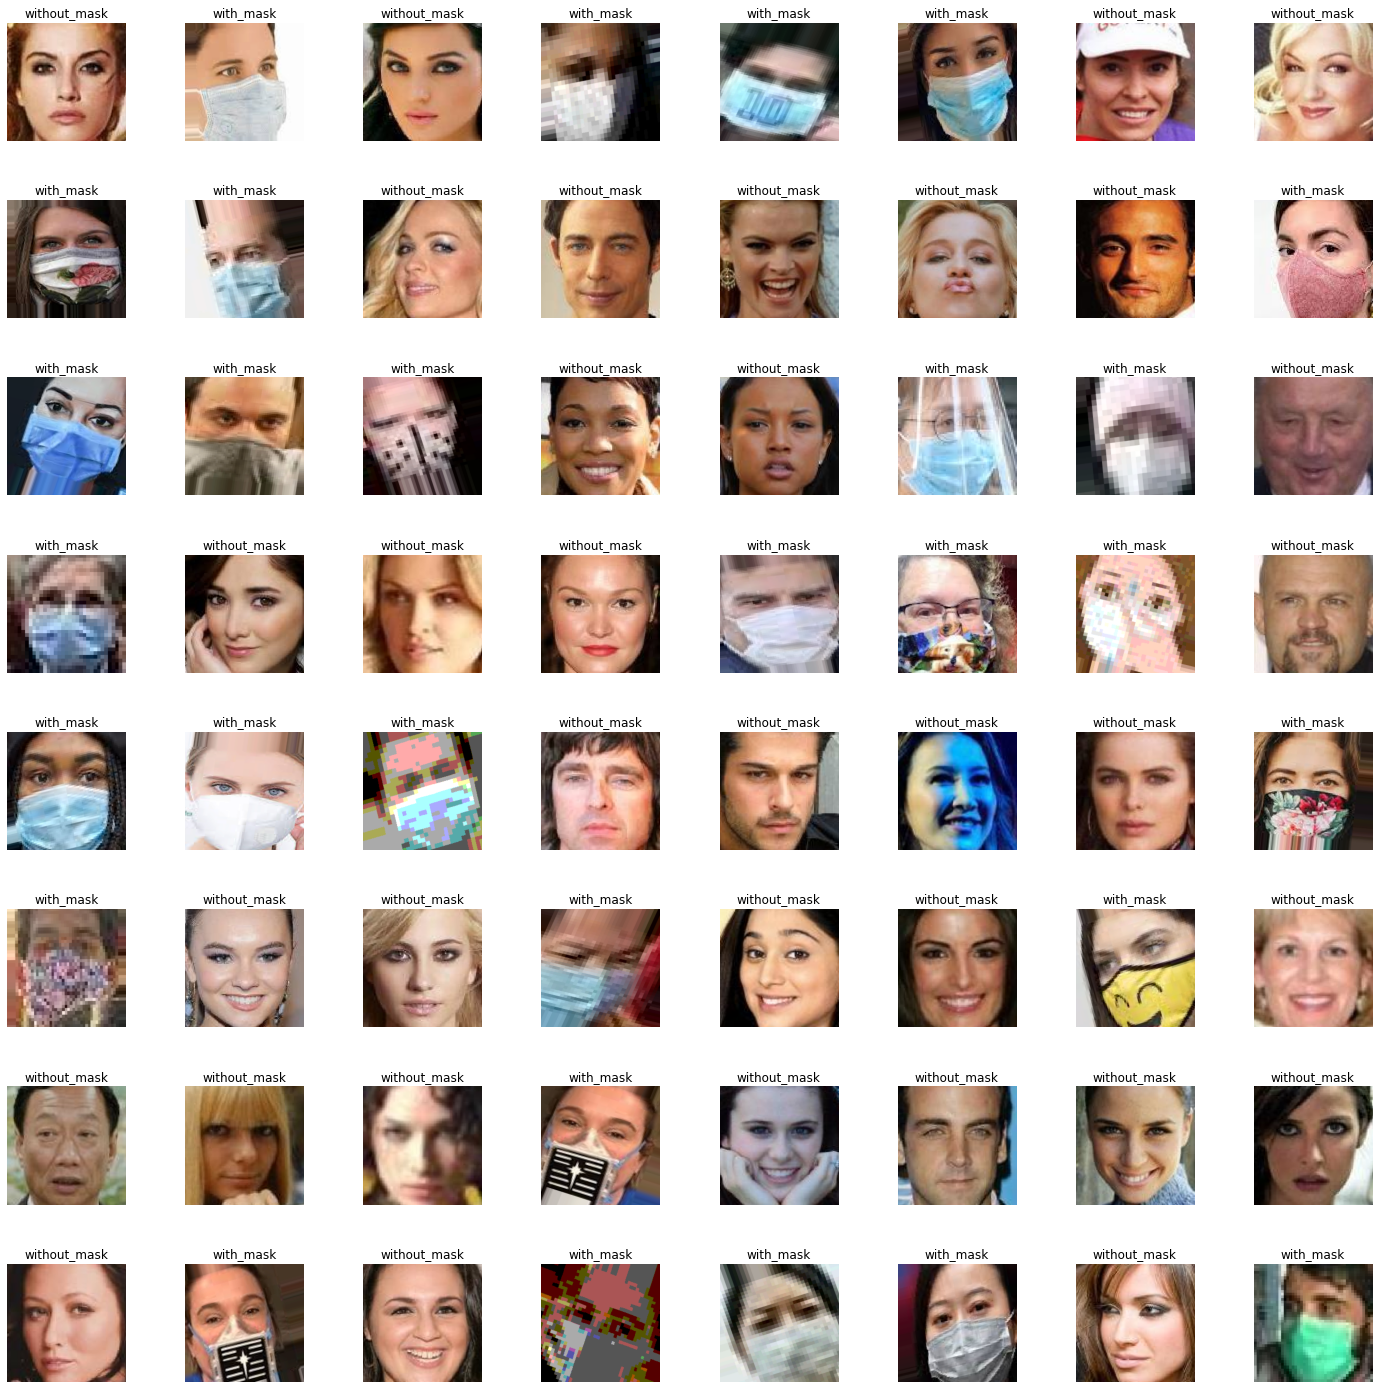

In [11]:
fig,axes=plt.subplots(8,8,figsize=(25,25))
axes=axes.ravel()#flatten 
for i in np.arange(0,64):
    axes[i].imshow(X_test[i])
    axes[i].set_title(labels[predictions[i]])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)

In [12]:
from sklearn.metrics import confusion_matrix,accuracy_score
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))

[[29  0]
 [ 0 35]]
1.0
